Import useful programs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ompy as om
import logging
import os
from datetime import date, datetime
import pandas as pd

import scipy as sp
from ipywidgets import widgets

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [2]:
om.__full_version__
print(om.__full_version__);

1.1.0.dev0+645df2f


In [3]:
# For reproducability we seed the random generator.
# Note that by default several other classes in ompy, such as all
# classes with multinest calculations have a default seed, too
np.random.seed(1382398)
np.random.seed(626237)

Script to choose Gg parameter

From RIPL3:

Since there is no data for 232 (i.e. 232+1n=233), I use a median of the 234 (234+1n=235), 236 (236+1n=237) and 238 (238+1n=239)

In [4]:
Gg_234 = 26
Gg_234_error = 4
Gg_236 = 23
Gg_236_error = 2
Gg_238 = 23.6
Gg_238_error = 0.8

Gg = np.asarray([Gg_234, Gg_236, Gg_238])
Gg_232 = np.mean(Gg)

#standard error of the mean
Gg_232_error_1 = sp.stats.sem(Gg)
#uncertainty
Gg_232_error_2 = Gg_232*np.sqrt( (Gg_234_error/Gg_234)**2 +  (Gg_236_error/Gg_236)**2 + (Gg_238_error/Gg_238)**2  )

#total_error
Gg_232_error = Gg_232_error_1+Gg_232_error_2


In [5]:
#Initialize parameters that decide how fast or good the normalization should be
#adding this to for easier access to these parameters:
ensemble_members=100 #should be >100 for "real"-run
multinest_livepoints = 400 #should be >400 for "real"-run

#other variables that is noce to have easy access to:

#How many keV per bin to be used in analysis
kev_per_bin_wish = 200

# The trapeziodal cutout of the FG-matrix i.e. the data to be used in analysis
Ex_min = 2970
Ex_max = 5200
Eg_min = 999.9
Eg_max = 6000

#Gg normalization parameter
Gg = Gg_232
Gg_err = Gg_232_error

#norm areas
gsfnorm_high = [3.7, 4.6]
gsfnorm_low = [1.1, 2.0]

nldnorm_low = [0.2, 0.6]
nldnorm_high = [1.3, 3.3]

now = str(datetime.now().strftime("%H:%M:%S"))
today = str(date.today())
path = 'normalized_data/U233_'+today+'_'+now+'/'

plot_path = path+'plots/'
matrix_path = path+'alfna_matrix/'
data_path = path+'data/'


if not os.path.exists(path):
    os.makedirs(path)
    
if not os.path.exists(plot_path):
    os.makedirs(plot_path)
    
if not os.path.exists(matrix_path):
    os.makedirs(matrix_path)
    
if not os.path.exists(data_path):
    os.makedirs(data_path)

infile = open(path+'README.txt', 'w+')
infile.write('This file contains variables used in the OmPy normalization \n')
infile.write('Name of directory indicates when the OmPy run was done \n \n')

infile.write('keV per bin: '+str(kev_per_bin_wish)+'\n \n')

infile.write('Trapezoid parameters: \n')
infile.write('Ex_min: '+str(Ex_min)+'\n')
infile.write('Ex_max: '+str(Ex_max)+'\n')
infile.write('Eg_min: '+str(Eg_min)+'\n')
infile.write('Eg_max: '+str(Eg_max)+'\n \n')

infile.write('Normalization Parameters: \n')
infile.write('Gg: '+str(Gg)+' +/- '+str(Gg_err)+'\n')
infile.write('NLD fit area low: '+str(nldnorm_low[0])+' - '+str(nldnorm_low[1])+'\n')
infile.write('NLD fit area high: '+str(nldnorm_high[0])+' - '+str(nldnorm_high[1])+'\n')
infile.write('gSF fit area low: '+str(gsfnorm_low[0])+' - '+str(gsfnorm_low[1])+'\n')
infile.write('gSF fit area high: '+str(gsfnorm_high[0])+' - '+str(gsfnorm_high[1])+'\n')
infile.close()


In [6]:
plt.rcParams["figure.dpi"] = 80
plt.rcParams["errorbar.capsize"] = 5
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams['font.size'] = 25
plt.rcParams['xtick.major.size'] = 12
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.major.size'] = 12
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.width'] = 2
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['lines.linewidth'] = 3.0
plt.rcParams['axes.linewidth'] = 1.5

def plot_3D(matrix, filename, xlabel='xlabel', ylabel='ylabel'):
    fig, ax = plt.subplots(figsize=(figwidth, figheigth))
    matrix.plot(ax=ax);
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    #fig.axes[1].tick_params(labelsize=tick_labelsize)
    ax.grid(color='k', linestyle='--', linewidth=.5)
    fig.savefig(filename, dpi=save_dpi)
    
def plot_2D(matrix, filename, projection_axis, xlabel='xlabel', ylabel='ylabel', yscale='log'):
    fig, ax = plt.subplots(figsize=(figwidth, figheigth))
    matrix.plot_projection(projection_axis, kind="step", ax=ax);
    plt.yscale(yscale)
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(color='k', linestyle='--', linewidth=.5)
    fig.savefig(filename, dpi=save_dpi)

In [7]:
def plot_matrix(matrix, fig_name, title, scale='log', x_label='$\gamma$-ray energy $E_\gamma$', ylabel='Excitation energy $E_x$'):
    fig, ax = plt.subplots(figsize=(10, 8))
    matrix.plot(ax=ax, scale=scale);
    ax.tick_params(axis='both', labelsize=18)
    ax.set_xlabel('$\gamma$-ray energy $E_\gamma$',fontsize=18)
    ax.set_ylabel('Excitation energy $E_x$',fontsize=18)
    ax.set_title(None)
    fig.suptitle(title, fontsize=20)
    fig.axes[1].tick_params(labelsize=18)
    fig.savefig(fig_name)

In [8]:
# Import raw matrix into instance of om.Matrix()
#raw = om.Matrix(path="alfna_matrix/alfna_U233")
#raw = om.Matrix(path="alfna_matrix/alfna_bigger_timecuts")
#raw_fiss = om.Matrix(path="alfna_matrix/alfna_fiss_bigger_timecuts")

raw = om.Matrix(path="calibrated_alfna_matrices/alfna_right_bg_timecuts")
raw_fiss = om.Matrix(path="calibrated_alfna_matrices/alfna_fiss_right_bg_timecuts")

#Rebin matrices
raw.rebin(0,factor=12)
raw.rebin(1,factor=12)
raw_fiss.rebin(0,factor=12)
raw_fiss.rebin(1,factor=12)


In [9]:
raw.save(matrix_path+'alfna_right_bg_timecuts.m')

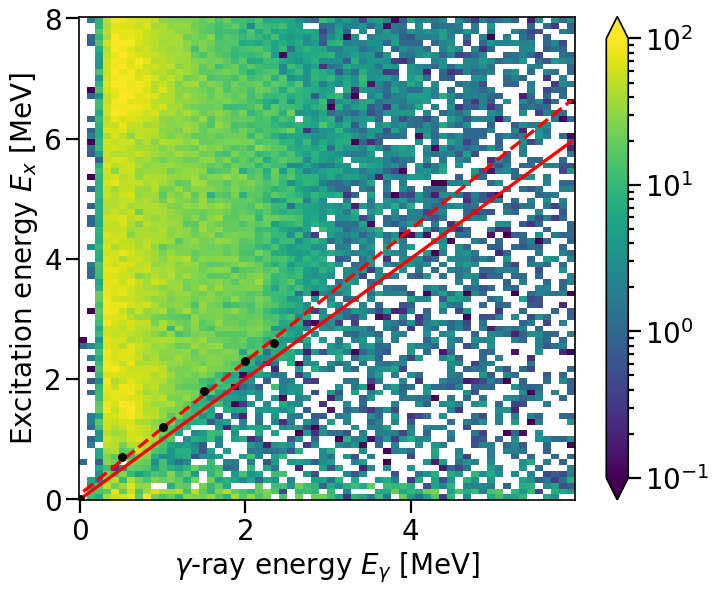

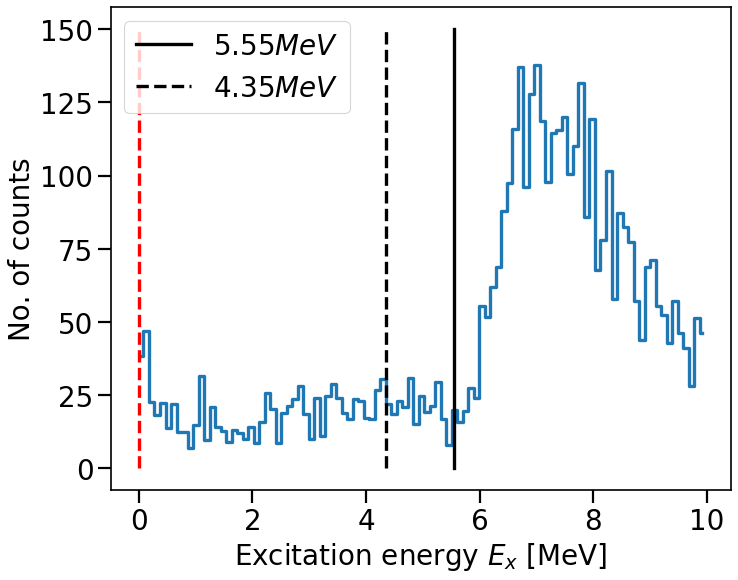

In [10]:
#plot raw matrix
raw_plot_big = raw.copy()
raw_plot_big.cut('Ex', 0, 8000)
raw_plot_big.cut('Eg', 0, 6000)
raw_plot_big.Ex = raw_plot_big.Ex*1e-3
raw_plot_big.Eg = raw_plot_big.Eg*1e-3

raw_plot_big_fiss = raw_fiss.copy()
raw_plot_big_fiss.cut('Ex', 0, 10000)
raw_plot_big_fiss.cut('Eg', 0, 6000)
raw_plot_big_fiss.Ex = raw_plot_big_fiss.Ex*1e-3
raw_plot_big_fiss.Eg = raw_plot_big_fiss.Eg*1e-3

Ex = raw_plot_big.Ex
Eg = raw_plot_big.Eg

fig, ax = plt.subplots()
raw_plot_big.plot(ax=ax, vmin=1e-1, vmax=1e2);
ax.set_xlabel('$\gamma$-ray energy $E_\gamma$ [MeV]')
ax.set_ylabel('Excitation energy $E_x$ [MeV]')
ax.plot(Eg, Eg, "r", label="E_x = E_g");

#Plot new diagonal to be used for calibration

#Linefit to calibrate Ex

#finding calibration points alog the diagonal
p0 = [0,0]
p1 = [.5, .7]
p2 = [1, 1.2]
p3 = [1.5, 1.8]
p4 = [2, 2.3]
p5 = [2.35, 2.6]

#linefit
y_linefit = np.asarray([p0[1], p1[1], p2[1], p3[1], p4[1], p5[1]])
x_linefit = np.asarray([p0[0], p1[0], p2[0], p3[0], p4[0], p5[0]])
z = np.polyfit(x_linefit, y_linefit, 1)
poly = np.poly1d(z)
new_diag = Eg*poly[1] + poly[0]
ax.plot(Eg, new_diag, 'r--');

#finding calibration points alog the diagonal
ax.plot(p0[0], p0[1], 'ko', markersize=7.0);
ax.plot(p1[0], p1[1], 'ko', markersize=7.0);
ax.plot(p2[0], p2[1], 'ko', markersize=7.0);
ax.plot(p3[0], p3[1], 'ko', markersize=7.0);
ax.plot(p4[0], p4[1], 'ko', markersize=7.0);
ax.plot(p5[0], p5[1], 'ko', markersize=7.0);

fig.savefig(plot_path+'raw_uncalibrated')



#plot projection
fig, ax = plt.subplots()
raw_plot_big_fiss.plot_projection('Ex', Emin=0, Emax=8, kind="step", ax=ax);
ax.set_ylabel('No. of counts')
ax.set_xlabel('Excitation energy $E_x$ [MeV]')
ax.plot([5.550, 5.550], [0, 150], color='black', label="$5.55MeV$");
ax.plot([4.350, 4.350], [0, 150], '--', color='black', label="$4.35MeV$");
ax.plot([0, 0], [0, 150], '--', color='red');
ax.legend(loc='upper left');
fig.savefig(plot_path+'Ex_py_fiss_uncalibrated')

In [11]:
#Calibrate Ex to new diagonal which is decided here
new_diag = raw.Ex*poly[1] + poly[0]

raw.Ex = 2*raw.Ex - new_diag
raw_fiss.Ex = 2*raw_fiss.Ex - new_diag

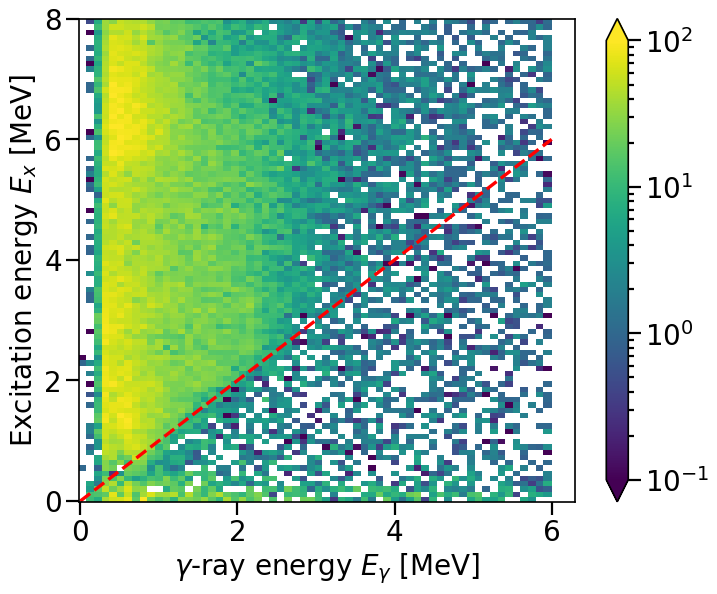

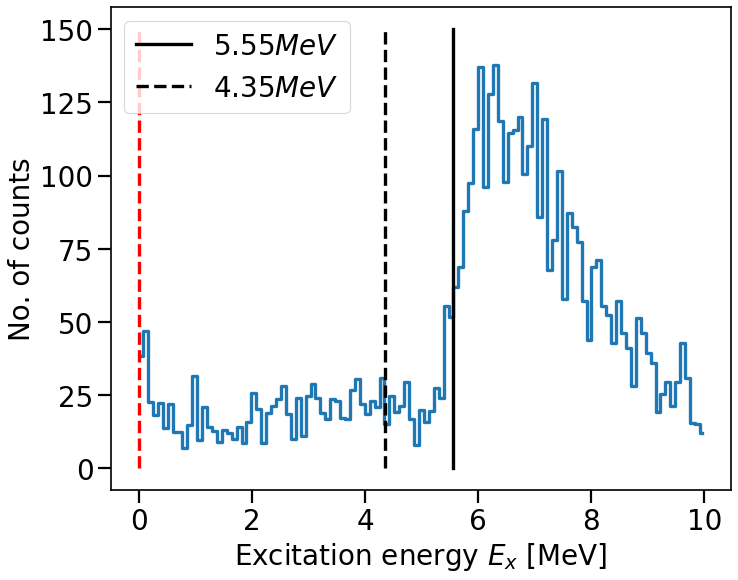

In [12]:
#plot raw matrix after calibration

raw_plot_big = raw.copy()
raw_plot_big.cut('Ex', 0, 8000)
raw_plot_big.cut('Eg', 0, 6000)
raw_plot_big.Ex = raw_plot_big.Ex*1e-3
raw_plot_big.Eg = raw_plot_big.Eg*1e-3

raw_plot_big_fiss = raw_fiss.copy()
raw_plot_big_fiss.cut('Ex', 0, 10000)
raw_plot_big_fiss.cut('Eg', 0, 6000)
raw_plot_big_fiss.Ex = raw_plot_big_fiss.Ex*1e-3
raw_plot_big_fiss.Eg = raw_plot_big_fiss.Eg*1e-3


fig, ax = plt.subplots()
raw_plot_big.plot(ax=ax, vmin=1e-1, vmax=1e2);
ax.set_xlabel('$\gamma$-ray energy $E_\gamma$ [MeV]')
ax.set_ylabel('Excitation energy $E_x$ [MeV]')
x = np.linspace(0, 6, len(raw.Ex))
ax.plot(x, x, "r--", label="E_x = E_g");
fig.savefig(plot_path+'raw_calibrated')


#plot projection
fig, ax = plt.subplots()
raw_plot_big_fiss.plot_projection('Ex', Emin=0, Emax=8, kind="step", ax=ax);
ax.set_ylabel('No. of counts')
ax.set_xlabel('Excitation energy $E_x$ [MeV]')
ax.plot([5.550, 5.550], [0, 150], color='black', label="$5.55MeV$");
ax.plot([4.350, 4.350], [0, 150], '--', color='black', label="$4.35MeV$");
ax.plot([0, 0], [0, 150], '--', color='red');
ax.legend(loc='upper left');
fig.savefig(plot_path+'Ex_py_fiss_calibrated')

New KeV per bin: 200.000


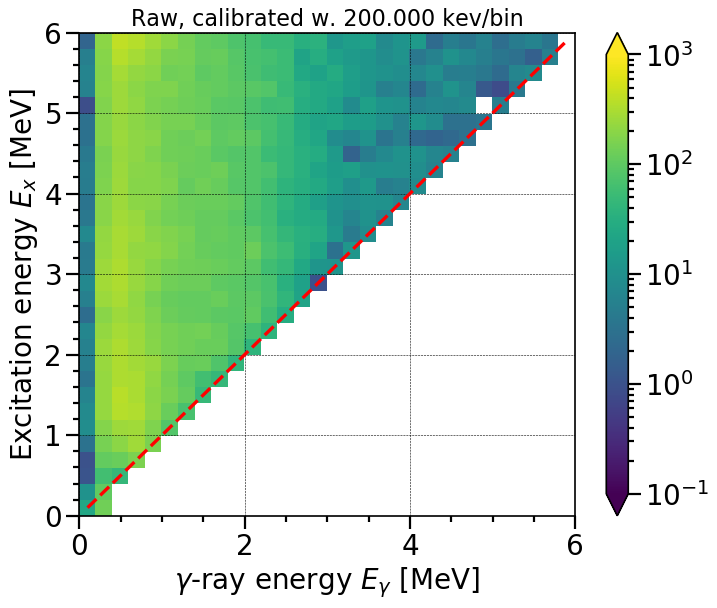

In [13]:
#Rebin raw matrix
def rebin_cut_raw(raw, kev_per_bin_wish, cut, keep=False):
    """
    Cuts raw matrix Eg and Ex at approximately cut and rebins Eg and Ex with new kev_per_bin_wish
    Cuts away diagonal too
    """
    
    raw_rebin = raw.copy()
    cut = kev_per_bin_wish*round(cut/kev_per_bin_wish)
    raw_rebin.cut('Ex', 0, cut)
    raw_rebin.cut('Eg', 0, cut)
 
    new_mids = np.linspace(kev_per_bin_wish/2, cut-(kev_per_bin_wish/2), int(cut/kev_per_bin_wish))    
    raw_rebin.rebin('Ex', mids=new_mids) #rebinning the Eg energy axis
    raw_rebin.rebin('Eg', mids=new_mids) #rebinning the Ex energy axis
    
    raw_rebin.cut_diagonal(E1=(kev_per_bin_wish, 0), E2 = (cut*2 + kev_per_bin_wish, cut*2))
    
    dEx = raw_rebin.Ex[1] - raw_rebin.Ex[0]
    print('New KeV per bin: %.3f'%dEx)
    
    raw_rebin_plot = raw_rebin.copy()
    raw_rebin_plot.Ex = raw_rebin_plot.Ex*1e-3
    raw_rebin_plot.Eg = raw_rebin_plot.Eg*1e-3
    Ex = raw_rebin_plot.Ex
    Eg = raw_rebin_plot.Eg

    #plot matrix
    fig, ax = plt.subplots()
    raw_rebin_plot.plot(ax=ax, vmin=1e-1, vmax=1e3);
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.set_xlabel('$\gamma$-ray energy $E_\gamma$ [MeV]')
    ax.set_ylabel('Excitation energy $E_x$ [MeV]')
    ax.plot(Ex, Eg, "r--");
    ax.grid(color='k', linestyle='--', linewidth=.5)
    fig.savefig(plot_path+'rebinned_matrix')
    ax.set_title('Raw, calibrated w. %.3f kev/bin'%dEx, fontsize=20)
    if keep==True:
        return raw_rebin
        #raw=raw_rebin
        #raw.rebin('Ex', mids=new_mids)
        #raw.rebin('Eg', mids=new_mids)
    if keep==False:
        return raw
        
keep = True
raw.save(matrix_path+'raw.m')
#kev_per_bin_wish = 250 #set this earlier in program
raw = rebin_cut_raw(raw, kev_per_bin_wish=kev_per_bin_wish, cut=6000, keep=keep)
raw.save(matrix_path+'raw_rebinned.m')

From the GettingStarted OmPy manual: "Eventhough this experiment was performed with CACTUS, we will now give an example as if the data was taken with OSCAR. This is beacause it is slightly easier to handle. For CACTUS, the response functions do not include the detector threshold; this has do be taken into account separately."

So, I need to include the detector threshold for CACTUS

2021-01-29 16:32:17,012 - ompy.response - INFO - Note: Spectra outside of 360.0 and 15000.0 are extrapolation only.
2021-01-29 16:32:17,229 - ompy.response - INFO - Note: Spectra outside of 360.0 and 15000.0 are extrapolation only.


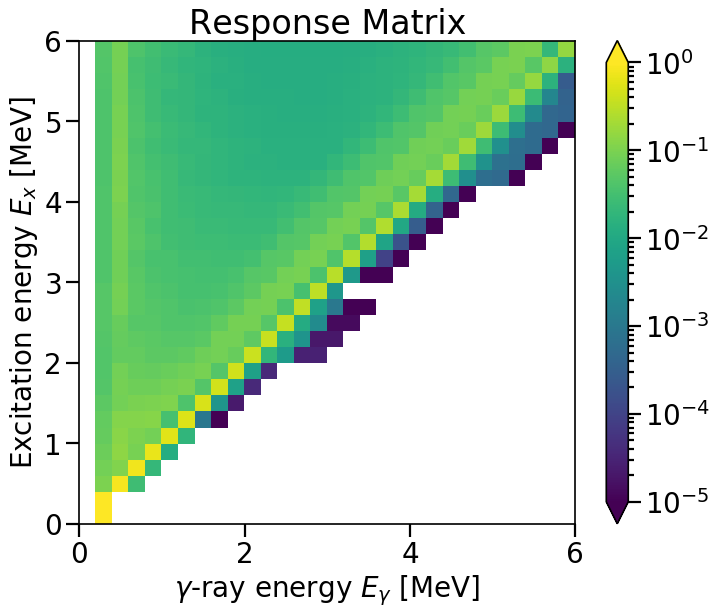

In [14]:
### GETTING RESPONSE MATRIX


logger = om.introspection.get_logger('response', 'INFO')
# Then do the same using OMpy functionality:
folderpath = "OCL_response_functions/nai2012_for_opt13"

# Energy calibration of resulting response matrix:
Eg = raw.Eg

# Experimental relative FWHM at 1.33 MeV of resulting array
fwhm_abs = 90.44 # (90/1330 = 6.8%) #CACTUS

response = om.Response(folderpath)
R_ompy_view, R_tab_view = response.interpolate(Eg, fwhm_abs=fwhm_abs, return_table=True)
# Magne recommends 1/10 of the actual resolution for unfolding purposes (see article)
R_ompy_unf, R_tab_unf = response.interpolate(Eg, fwhm_abs=fwhm_abs/10, return_table=True)

R_ompy_view.save(matrix_path+"R_ompy_view.m")
R_ompy_unf.save(matrix_path+"R_ompy_unf.m")
R_tab_view.to_pickle(matrix_path+"R_tab_view.pkl")
R_tab_unf.to_pickle(matrix_path+"R_tab_unf.pkl")

# adding response function for CACTUS
fthreshold = sp.interpolate.interp1d([30., 80., 122., 183., 244., 294., 344., 562., 779., 1000.],
                      [0.0, 0.0, 0.0, 0.06, 0.44, 0.60, 0.87, 0.99, 1.00, 1.00],
                      fill_value="extrapolate") #from mama-software ('folding.f')

def apply_detector_threshold(response, table, fthreshold):
    thres = fthreshold(response.Eg)
    response.values = response.values * thres
    # renormalize
    response.values = om.div0(response.values, response.values.sum(axis=1)[:, np.newaxis])
    table["eff_tot"] *= thres

apply_detector_threshold(R_ompy_unf, R_tab_unf, fthreshold)
apply_detector_threshold(R_ompy_view, R_tab_view, fthreshold)


R_ompy_view_plot = R_ompy_view.copy()
R_ompy_view_plot.Ex = R_ompy_view_plot.Ex*1e-3
R_ompy_view_plot.Eg = R_ompy_view_plot.Eg*1e-3

fig, ax = plt.subplots()
R_ompy_view_plot.plot(ax=ax, scale="log", vmin=1e-5, vmax=1e0);
ax.tick_params(axis='both')
ax.set_xlabel('$\gamma$-ray energy $E_\gamma$ [MeV]')
ax.set_ylabel('Excitation energy $E_x$ [MeV]')
ax.set_title('Response Matrix')
fig.savefig(plot_path+'response_matrix_%.0i_kevperbin'%kev_per_bin_wish)

Text(0.5, 1, 'Unfolded')

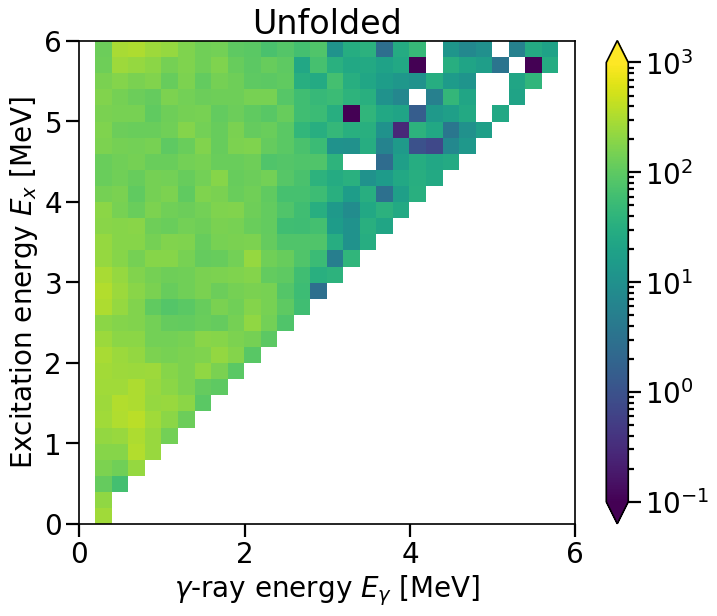

In [15]:
### UNFOLDING

# You can decide to log information and set the logging level (info/debug)
logger = om.introspection.get_logger('unfolder', 'INFO')

# We need to remove negative counts (unphysical) in the raw matrix before unfolding:
raw_positive = raw.copy()
raw_positive.fill_and_remove_negative(window_size=20)

# With compton subtraction and all tweaks
unfolder = om.Unfolder(num_iter = 500, response=R_ompy_unf)
unfolder.use_compton_subtraction = True # default
unfolder.response_tab = R_tab_unf
# Magne suggests some "tweaks" for a better unfolding performance. Default is 1 for all.
unfolder.FWHM_tweak_multiplier = {"fe": 1., "se": 1.1,
                                     "de": 1.3, "511": 0.9} #SJEKK DETTE
unfolded = unfolder(raw_positive)

unfolded_plot = unfolded.copy()
unfolded_plot.Ex = unfolded_plot.Ex*1e-3
unfolded_plot.Eg = unfolded_plot.Eg*1e-3

fig, ax = plt.subplots()
unfolded_plot.plot(ax=ax, scale="log", vmin=1e-1, vmax=1e3);
ax.set_xlabel('$\gamma$-ray energy $E_\gamma$ [MeV]')
ax.set_ylabel('Excitation energy $E_x$ [MeV]')
ax.set_title('')
fig.savefig(plot_path+'unfolded_matrix_%.0i_kevperbin'%kev_per_bin_wish)
ax.set_title('Unfolded')



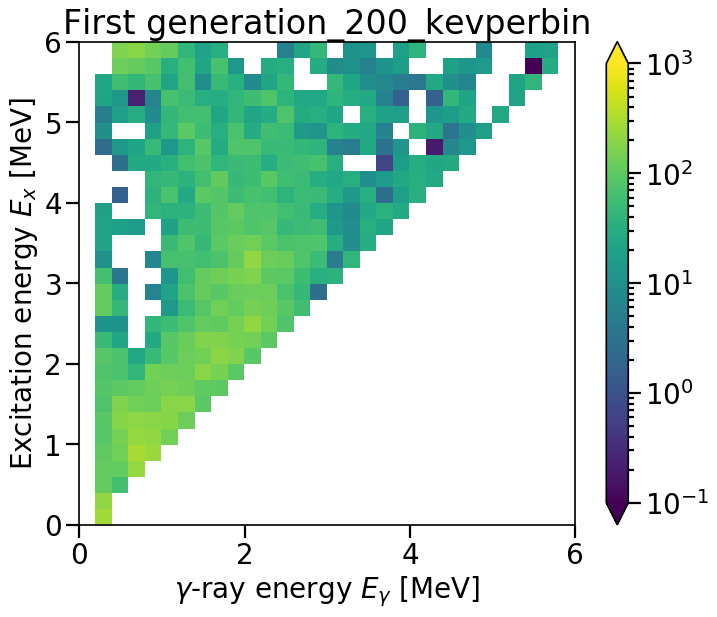

In [16]:
### Generate the first generation matrix

firstgen = om.FirstGeneration()
primary = firstgen(unfolded)


primary_plot = primary.copy()
primary_plot.Ex = primary_plot.Ex*1e-3
primary_plot.Eg = primary_plot.Eg*1e-3

fig, ax = plt.subplots()
primary_plot.plot(ax=ax, scale="log", vmin=1e-1, vmax=1e3);
ax.set_xlabel('$\gamma$-ray energy $E_\gamma$ [MeV]')
ax.set_ylabel('Excitation energy $E_x$ [MeV]')
ax.set_title('First generation_%.0i_kevperbin'%kev_per_bin_wish);

In [17]:
### Propagating statistical uncertainties

logger = om.introspection.get_logger('ensemble', 'INFO')


# Tell the `Ensemble` class which raw spectrum, what kind of unfolder and first
# generations method to use.
# Note: This will have the same setting as above. We could for example have
# set the first generations method to use a different "valley_collection", or a
# differnt type of "multiplicity_estimation"
ensemble = om.Ensemble(raw=raw_positive)
ensemble.unfolder = unfolder
ensemble.first_generation_method = firstgen
# Generates N perturbated members; here just 10 to speed it up
# the `regenerate` flag ensures, that we don't load from disk; which might result in expected results
# if we have changed something in the input `raw` matrix.
ensemble.generate(ensemble_members, regenerate=True)

2021-01-29 16:32:20,204 - ompy.ensemble - INFO - Start normalization with 3 cpus
2021-01-29 16:32:20,503 - ompy.ensemble - INFO - Generating/loading 0
2021-01-29 16:32:20,520 - ompy.ensemble - INFO - Generating/loading 1
2021-01-29 16:32:20,538 - ompy.ensemble - INFO - Generating/loading 2


2021-01-29 16:32:20,974 - ompy.ensemble - INFO - Generating/loading 3
2021-01-29 16:32:21,036 - ompy.ensemble - INFO - Generating/loading 4
2021-01-29 16:32:21,060 - ompy.ensemble - INFO - Generating/loading 5
2021-01-29 16:32:21,349 - ompy.ensemble - INFO - Generating/loading 6
2021-01-29 16:32:21,547 - ompy.ensemble - INFO - Generating/loading 7
2021-01-29 16:32:21,614 - ompy.ensemble - INFO - Generating/loading 8
2021-01-29 16:32:21,794 - ompy.ensemble - INFO - Generating/loading 9
2021-01-29 16:32:22,040 - ompy.ensemble - INFO - Generating/loading 10
2021-01-29 16:32:22,073 - ompy.ensemble - INFO - Generating/loading 11
2021-01-29 16:32:22,233 - ompy.ensemble - INFO - Generating/loading 12
2021-01-29 16:32:22,569 - ompy.ensemble - INFO - Generating/loading 13
2021-01-29 16:32:22,677 - ompy.ensemble - INFO - Generating/loading 14
2021-01-29 16:32:22,723 - ompy.ensemble - INFO - Generating/loading 15
2021-01-29 16:32:23,109 - ompy.ensemble - INFO - Generating/loading 16
2021-01-29 16

Extract Nuclear level density and gamma strength function

2021-01-29 16:32:37,532 - ompy.extractor - INFO - Infering calibration that calibration is in keV.
2021-01-29 16:32:37,552 - ompy.extractor - INFO - Minimizing
2021-01-29 16:32:38,060 - ompy.extractor - INFO - Optimization terminated successfully.
2021-01-29 16:32:38,061 - ompy.extractor - INFO -          Current function value: 332.249857
2021-01-29 16:32:38,062 - ompy.extractor - INFO -          Iterations: 6
2021-01-29 16:32:38,063 - ompy.extractor - INFO -          Function evaluations: 3314
2021-01-29 16:32:38,118 - ompy.extractor - INFO - Infering calibration that calibration is in keV.
2021-01-29 16:32:38,119 - ompy.extractor - INFO - Minimizing
2021-01-29 16:32:38,609 - ompy.extractor - INFO - Optimization terminated successfully.
2021-01-29 16:32:38,610 - ompy.extractor - INFO -          Current function value: 372.790917
2021-01-29 16:32:38,611 - ompy.extractor - INFO -          Iterations: 6
2021-01-29 16:32:38,612 - ompy.extractor - INFO -          Function evaluations: 334

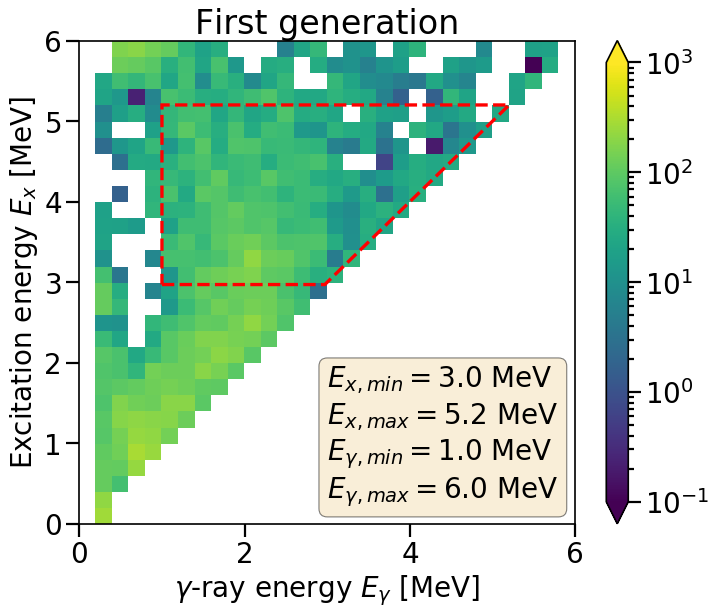

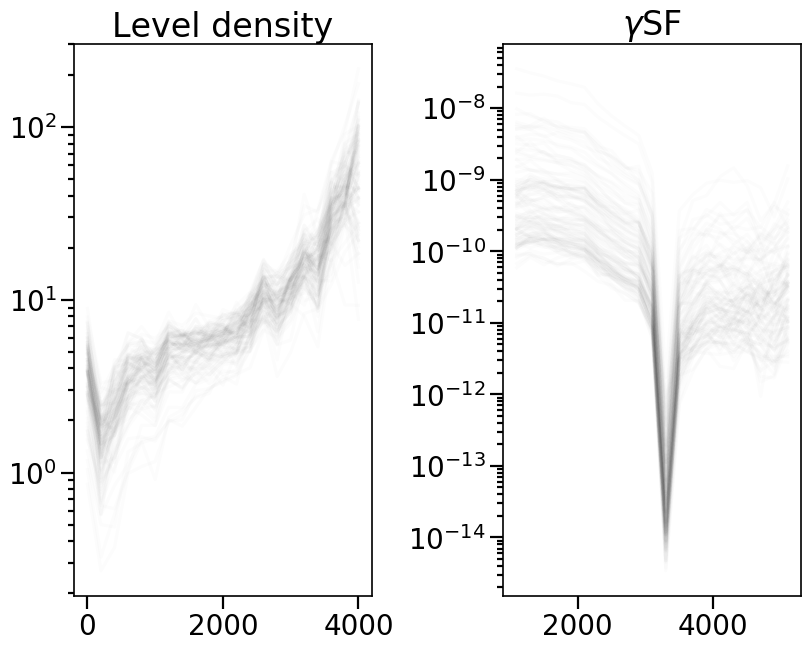

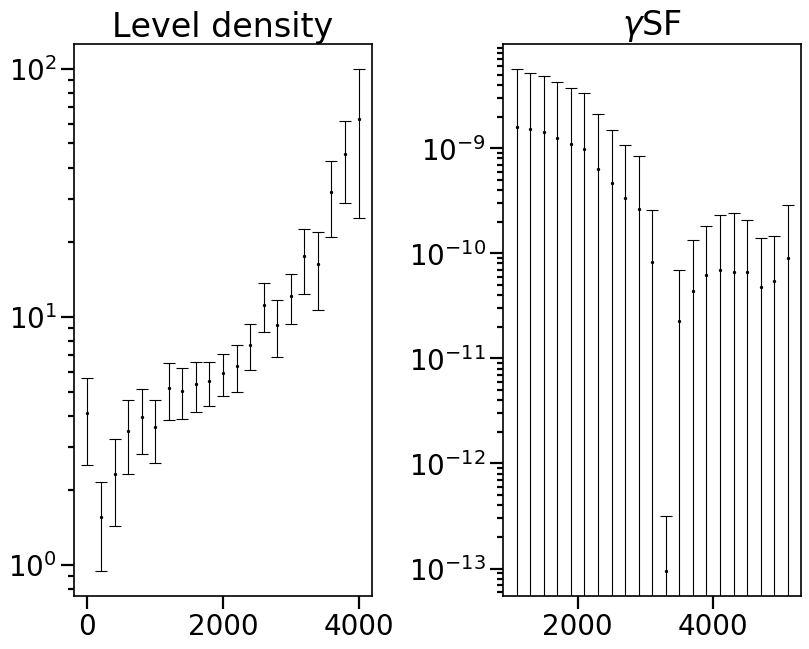

In [18]:
extlog = om.introspection.get_logger('extractor', 'INFO')
# Trapezoidal cuts. These are now set earlier in program, for easier availability

primary_plot = primary.copy()
primary_plot.Ex = primary_plot.Ex*1e-3
primary_plot.Eg = primary_plot.Eg*1e-3

#plot primary matrix with trapezoidal cuts:
fig, ax = plt.subplots()
primary_plot.plot(ax=ax, scale="log", vmin=1e-1, vmax=1e3);
ax.set_xlabel('$\gamma$-ray energy $E_\gamma$ [MeV]')
ax.set_ylabel('Excitation energy $E_x$ [MeV]')
# Trapez
x = [Eg_min*1e-3, Ex_min*1e-3, Ex_max*1e-3, Eg_min*1e-3]
y = [Ex_min*1e-3, Ex_min*1e-3, Ex_max*1e-3, Ex_max*1e-3]
textstr = '\n'.join((
    r'$E_{x, min}=%.1f$ MeV' % (Ex_min*1e-3, ),
    r'$E_{x, max}=%.1f$ MeV' % (Ex_max*1e-3, ),
    r'$E_{\gamma, min}=%.1f$ MeV' % (Eg_min*1e-3, ),
    r'$E_{\gamma, max}=%.1f$ MeV' % (Eg_max*1e-3, )))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(.5, 0.33, textstr, transform=ax.transAxes, verticalalignment='top', bbox=props)

ax.add_patch(patches.Polygon(xy=list(zip(x,y)), fill=False, linewidth=3.0, color='r', linestyle='--'))
ax.set_title('')
fig.savefig(plot_path+'firstgen_matrix')
ax.set_title('First generation')


#Perform trapezoidal cut
trapezoid_cut = om.Action('matrix')
trapezoid_cut.trapezoid(Ex_min=Ex_min, Ex_max=Ex_max, Eg_min=Eg_min, Eg_max = Ex_max+kev_per_bin_wish, inplace=True)
extractor = om.Extractor()
extractor.trapezoid = trapezoid_cut


E_rebinned = ensemble.get_firstgen(0).Ex
ensemble.rebin(E_rebinned, member="firstgen")

extractor.extract_from(ensemble, regenerate=True)

extractor.plot(scale='log', plot_mean=False);
plt.savefig(plot_path+'unnormed_new_falsemean')

extractor.plot(scale='log', plot_mean=True);
plt.savefig(plot_path+'unnormed_new_truemean')

In [19]:
# let's remove the nan-valued elements (unconstrained elements) for the further analysis
for nld in extractor.nld:
    nld.cut_nan()

for gsf in extractor.gsf:
    gsf.cut_nan()

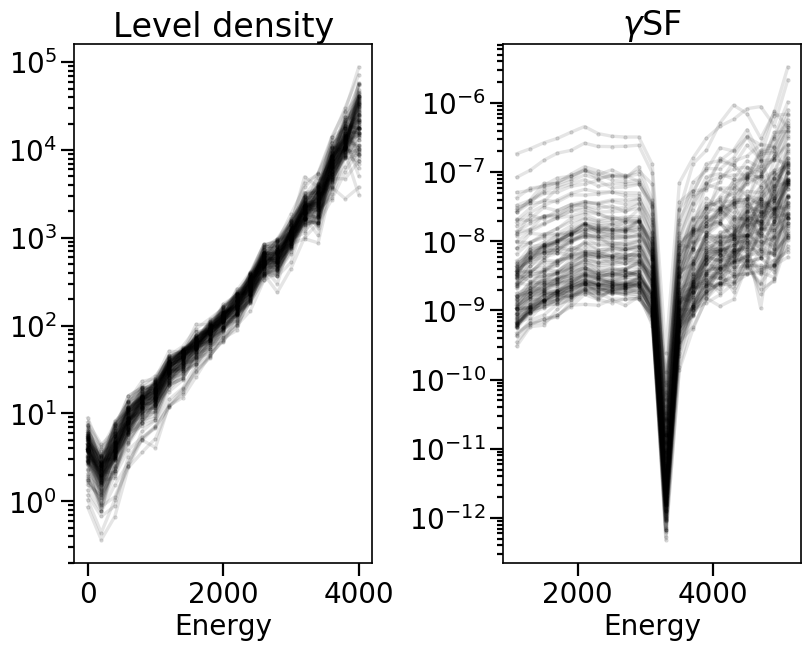

In [20]:
def plot_transformed(alpha, A=1, B=1):
    fig, ax = plt.subplots(1, 2, constrained_layout=True)
    for nld, gsf in zip(extractor.nld, extractor.gsf):
        nld.transform(const=A, alpha=alpha, inplace=False).plot(ax=ax[0], scale="log", color='k', alpha=1/10)
        gsf.transform(const=B, alpha=alpha, inplace=False).plot(ax=ax[1], scale="log", color='k', alpha=1/10)
    ax[0].set_title("Level density")
    ax[1].set_title(r"$\gamma$SF")

plot_transformed(alpha=0.0015)

Normalization parameters and explanation:

D0: 4.6 +/- 0.7 Average s-wave resonance spacing D0 [eV] Taken from https://www-nds.iaea.org/RIPL-3/, https://www-nds.iaea.org/cgi-bin/ripl_den_ldp.pl?Z=92&A=233

Sn: Neutron separation energy [MeV] Taken from https://www-nds.iaea.org/RIPL-3/, https://www-nds.iaea.org/cgi-bin/ripl_levels.pl?Z=92&A=233

Spincut pars. Parameters necessary for the spin cut model:
    NLDa: Level density parameter. Taken from https://journals.aps.org/prc/abstract/10.1103/PhysRevC.80.054310 (Egidy, Bucurescu 2009)
    
    Eshift: Total backshift parameter. Taken from https://journals.aps.org/prc/abstract/10.1103/PhysRevC.80.054310 (Egidy, Bucurescu 2009)
    
    sigma2_disc: spin cutoff parameter discrepancy?
    
Jtarget: 5/2+ “Target” (A-1 nucleus) ground state spin. From https://www-nds.iaea.org/cgi-bin/ripl_levels.pl?Z=92&A=233

nldnorm:
    limit_low:
    
    limit_high:
    
gsfnorm:
    Gg: Total average radiative width [meV]
    
    
printout from ompy source-code 
        """ Get the square of the spin cut for a specified model 

        if model == "const":
            pars_req = {"sigma"}
            return call_model(self.gconst, pars, pars_req)
        elif model == "EB05":
            pars_req = {"mass", "NLDa", "Eshift"}
            return call_model(self.gEB05, pars, pars_req)
        elif model == "EB09_CT":
            pars_req = {"mass"}
            return call_model(self.gEB09_CT, pars, pars_req)
        elif model == "EB09_emp":
            pars_req = {"mass", "Pa_prime"}
            return call_model(self.gEB09_emp, pars, pars_req)
        elif model == "Disc_and_EB05":
            pars_req = {"mass", "NLDa", "Eshift", "Sn", "sigma2_disc"}
            return call_model(self.gDisc_and_EB05, pars, pars_req)
            
The different spin-cutoff models to use. Which one?

In [21]:
##Normalization parameters
regenerator = True
def init_normalizers():
    
    norm_pars = om.NormalizationParameters(name='233U')
    norm_pars.D0 = [4.6, 0.7]  # eV #SJEKK
    norm_pars.Sn = [5.762, 0] # MeV #SJEKK

    #Which spin-cutoff model to use (uncomment to use):

    #norm_pars.spincutModel = 'Disc_and_EB05'  # see eg. Guttormsen et al., 2017, PRC 96, 024313
    #norm_pars.spincutPars = {"mass":233, "NLDa":25.395, "Eshift":-0.519, "Sn": norm_pars.Sn[0], "sigma2_disc":[1.5, 3.6]}

    #norm_pars.spincutModel = 'EB09_CT'
    #norm_pars.spincutPars = {"mass":233}

    norm_pars.spincutModel = 'EB05'
    norm_pars.spincutPars = {"mass":233, "NLDa":25.395, "Eshift":-0.519}


    norm_pars.Jtarget = 0 # A-1 nucleus (232U)

    # NLD normalizer parameters

    normlog = om.introspection.get_logger('normalizer_nld', 'INFO')
    nldnorm = om.NormalizerNLD(nld=extractor.nld[0], discrete='discrete_levels_U233.txt', regenerate=regenerator)
    nldnorm.smooth_levels_fwhm = 0.1 #0.1 MeV = 100keV is default
    nldnorm.limit_low = nldnorm_low
    nldnorm.limit_high = nldnorm_high
    
    #nldnorm.bounds["A"] = [0.001, 100]
    #nldnorm.bounds["alpha"] = [1, 2]
    nldnorm.bounds['T'] = [0.2, 0.6]

    # gSF normalizer parameters

    normlog = om.introspection.get_logger('normalizer_gsf', 'INFO')
    gsfnorm = om.NormalizerGSF(normalizer_nld=nldnorm, gsf=extractor.gsf[0], regenerate=regenerator)

    # to be used for gsf normalization
    norm_pars.Gg = [Gg, Gg_err] 

    #dont delete
    #gsfnorm.model_high.Efit = [3.7, 4.6]
    #gsfnorm.model_low.Efit = [1.8, 2.4]

    gsfnorm.model_high.Efit = gsfnorm_high
    gsfnorm.model_low.Efit = gsfnorm_low
    
    
    gsfnorm.norm_pars = norm_pars
    nldnorm.norm_pars = norm_pars
    
    #rhoSn and error as calculated in OmPy
    rhoSn = nldnorm.nldSn_from_D0(norm_pars.D0, norm_pars.Sn, norm_pars.Jtarget, norm_pars.spincutModel, norm_pars.spincutPars)
    rel_err = rhoSn[1]*(norm_pars.D0[1]/norm_pars.D0[0])
    
    #write certain normalization parameters to README-file
    infile = open(path+'README.txt', 'a')
    infile.write('rhoSn: '+str(rhoSn[1])+' +/- '+str(rel_err)+'\n')
    infile.close()
    
    return nldnorm,gsfnorm

Simultaneous normalization of the whole ensemble

In [22]:
def norm_sim(nldnorm, gsfnorm):
    normlog = om.introspection.get_logger('normalizer_simultan', 'INFO')
    simnorm = om.NormalizerSimultan(normalizer_nld=nldnorm, normalizer_gsf=gsfnorm, regenerate=regenerator)
    simnorm.gsf = extractor.gsf[0]
    simnorm.nld = extractor.nld[0]

    # running faster than the default 400 given less precise answers
    # For propper calc. you may rather increase this to > 400.
    simnorm.multinest_kwargs["n_live_points"] = multinest_livepoints
    simnorm.normalize()
    #simnorm.save_results_txt('normalized_data/simnorm_nld_gsf_%.0i_kevperbin'%kev_per_bin_wish)
    
    #plot normalization
    fig, ax = plt.subplots(1,2)
    simnorm.plot(ax=ax, add_figlegend=False);
    fig.legend(loc=9, ncol=4, frameon=True)
    ax[1].set_xlabel('$\gamma$-ray energy $E_\gamma$ [keV]')
    ax[0].set_xlabel('Excitation energy $E_x$ [keV]')
    ax[0].set_ylabel('Nuclear Level Density (NLD)')
    ax[1].set_ylabel('$\gamma SF$')
    fig.savefig(plot_path+'simnorm')
    return simnorm, fig


2021-01-29 16:34:09,493 - ompy.normalizer_nld - INFO - DE results:
┌────────────────────┬────────────────────┬────────────────────┬─────────────────────┐
│ A                  │ α [MeV⁻¹]          │ T [MeV]            │ Eshift [MeV]        │
╞════════════════════╪════════════════════╪════════════════════╪═════════════════════╡
│ 17.502249599273682 │ 1.4779338230016696 │ 0.3879178425453886 │ -0.5219193765265793 │
└────────────────────┴────────────────────┴────────────────────┴─────────────────────┘
2021-01-29 16:34:09,584 - ompy.normalizer_gsf - INFO - Normalizing #0
2021-01-29 16:34:09,618 - ompy.normalizer_simultan - INFO - DE results/initial guess:
┌────────────────────┬────────────────────┬────────────────────┬─────────────────────┬───────────────────┐
│ A                  │ α [MeV⁻¹]          │ T [MeV]            │ Eshift [MeV]        │ B                 │
╞════════════════════╪════════════════════╪════════════════════╪═════════════════════╪═══════════════════╡
│ 17.502249599273682 

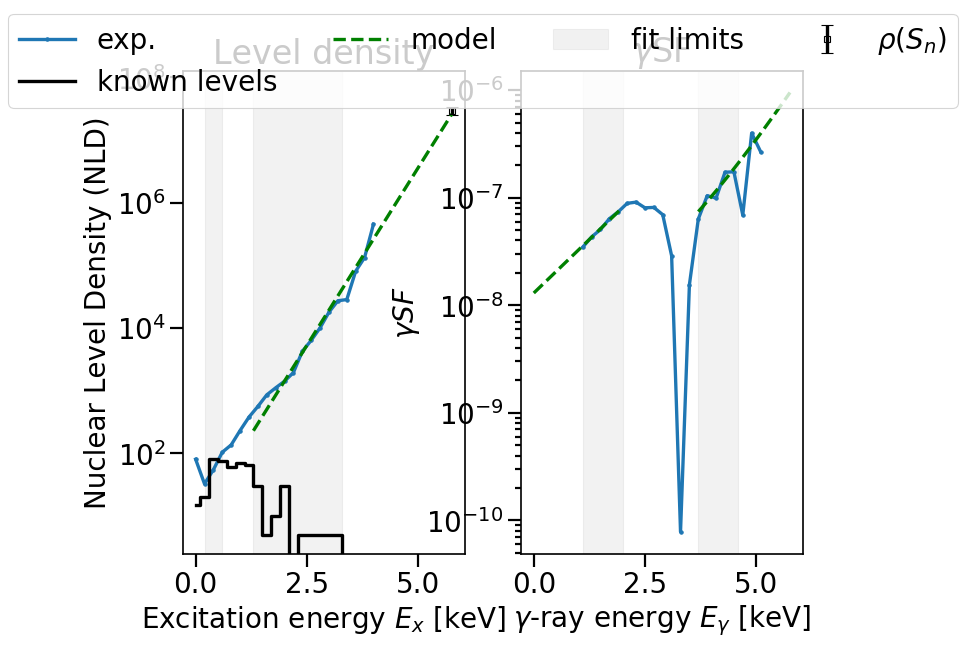

In [23]:
nldnorm, gsfnorm = init_normalizers()
simnorm, fig = norm_sim(nldnorm, gsfnorm)

2021-01-29 16:35:42,283 - ompy.normalizer_nld - INFO - 

---------
Normalizing nld #0
2021-01-29 16:35:43,410 - ompy.normalizer_nld - INFO - DE results:
┌────────────────────┬────────────────────┬────────────────────┬─────────────────────┐
│ A                  │ α [MeV⁻¹]          │ T [MeV]            │ Eshift [MeV]        │
╞════════════════════╪════════════════════╪════════════════════╪═════════════════════╡
│ 17.502249599273682 │ 1.4779338230016696 │ 0.3879178425453886 │ -0.5219193765265793 │
└────────────────────┴────────────────────┴────────────────────┴─────────────────────┘
2021-01-29 16:35:43,411 - ompy.normalizer_nld - INFO - Starting multinest
  analysing data from multinest/nld_norm_0_.txt
2021-01-29 16:36:00,080 - ompy.normalizer_nld - INFO - Multinest results:
┌────────────┬─────────────┬───────────────┬──────────────┐
│ A          │ α [MeV⁻¹]   │ T [MeV]       │ Eshift [MeV] │
╞════════════╪═════════════╪═══════════════╪══════════════╡
│ 19.0 ± 3.9 │ 1.43 ± 0.14 │ 0.390 ±

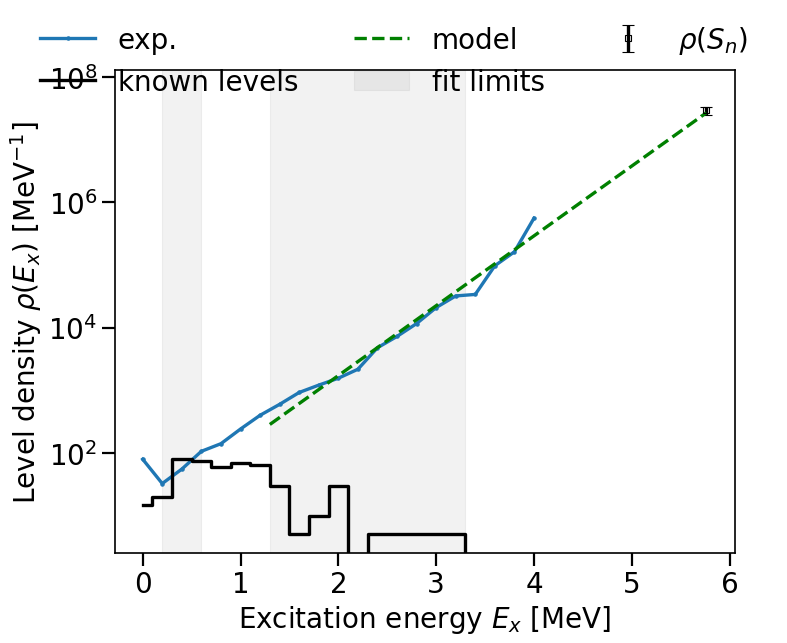

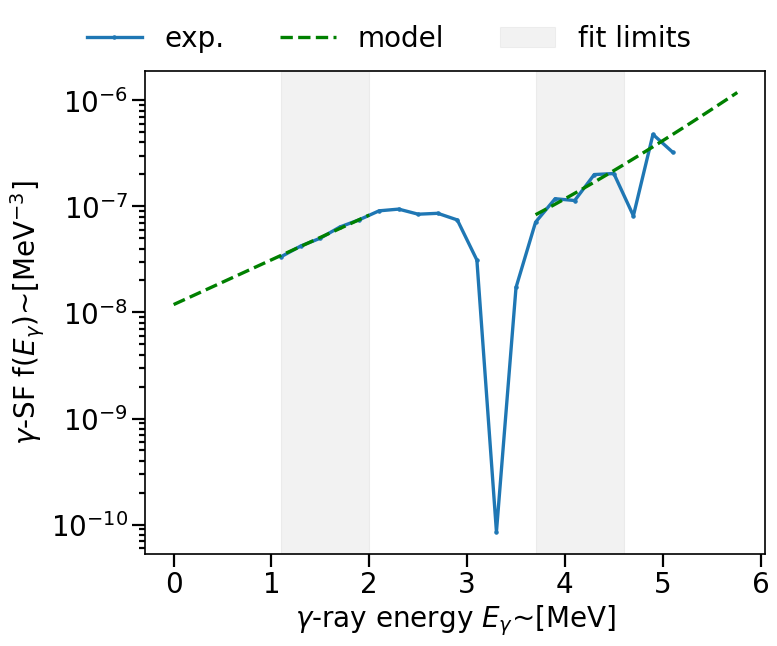

In [24]:
nldnorm.normalize()
nldnorm.plot();
gsfnorm.normalize()
gsfnorm.plot();

In [25]:
def norm_sim_ensemble(nldnorm, gsfnorm):
    normlog = om.introspection.get_logger('normalizer_emsemble_simultan', 'INFO')
    ensemblenorm_sim = om.EnsembleNormalizer(extractor=extractor, normalizer_simultan=simnorm, regenerate=regenerator)
    ensemblenorm_sim.normalize()
    ensemblenorm_sim.save_results_txt(data_path)

    fig, ax = plt.subplots(1,2, figsize=(20, 11))
    ensemblenorm_sim.plot(ax=ax, n_plot=5, add_figlegend=False)#, random_state=np.random.default_rng(65546645));
    fig.legend(loc=9, ncol=4, frameon=True)
    ax[1].set_xlabel('$\gamma$-ray energy $E_\gamma$ [keV]')
    ax[0].set_xlabel('Excitation energy $E_x$ [keV]')
    ax[0].set_ylabel('Level Density $\\rho(E_x)$ $[MeV^{-1}]$')
    ax[1].set_ylabel('$\gamma-SF$ $f(E_\gamma)\sim [MeV^{-3}]$')
    fig.savefig(plot_path+'ensemble_simnorm')
    return ensemblenorm_sim, fig

2021-01-29 16:36:03,479 - ompy.normalizer_nld - INFO - DE results:
┌────────────────────┬────────────────────┬────────────────────┬─────────────────────┐
│ A                  │ α [MeV⁻¹]          │ T [MeV]            │ Eshift [MeV]        │
╞════════════════════╪════════════════════╪════════════════════╪═════════════════════╡
│ 17.502249599273682 │ 1.4779338230016696 │ 0.3879178425453886 │ -0.5219193765265793 │
└────────────────────┴────────────────────┴────────────────────┴─────────────────────┘
2021-01-29 16:36:03,568 - ompy.normalizer_gsf - INFO - Normalizing #0
2021-01-29 16:36:03,579 - ompy.normalizer_simultan - INFO - DE results/initial guess:
┌────────────────────┬────────────────────┬────────────────────┬─────────────────────┬───────────────────┐
│ A                  │ α [MeV⁻¹]          │ T [MeV]            │ Eshift [MeV]        │ B                 │
╞════════════════════╪════════════════════╪════════════════════╪═════════════════════╪═══════════════════╡
│ 17.502249599273682 

ValueError: could not broadcast input array from shape (20) into shape (21)

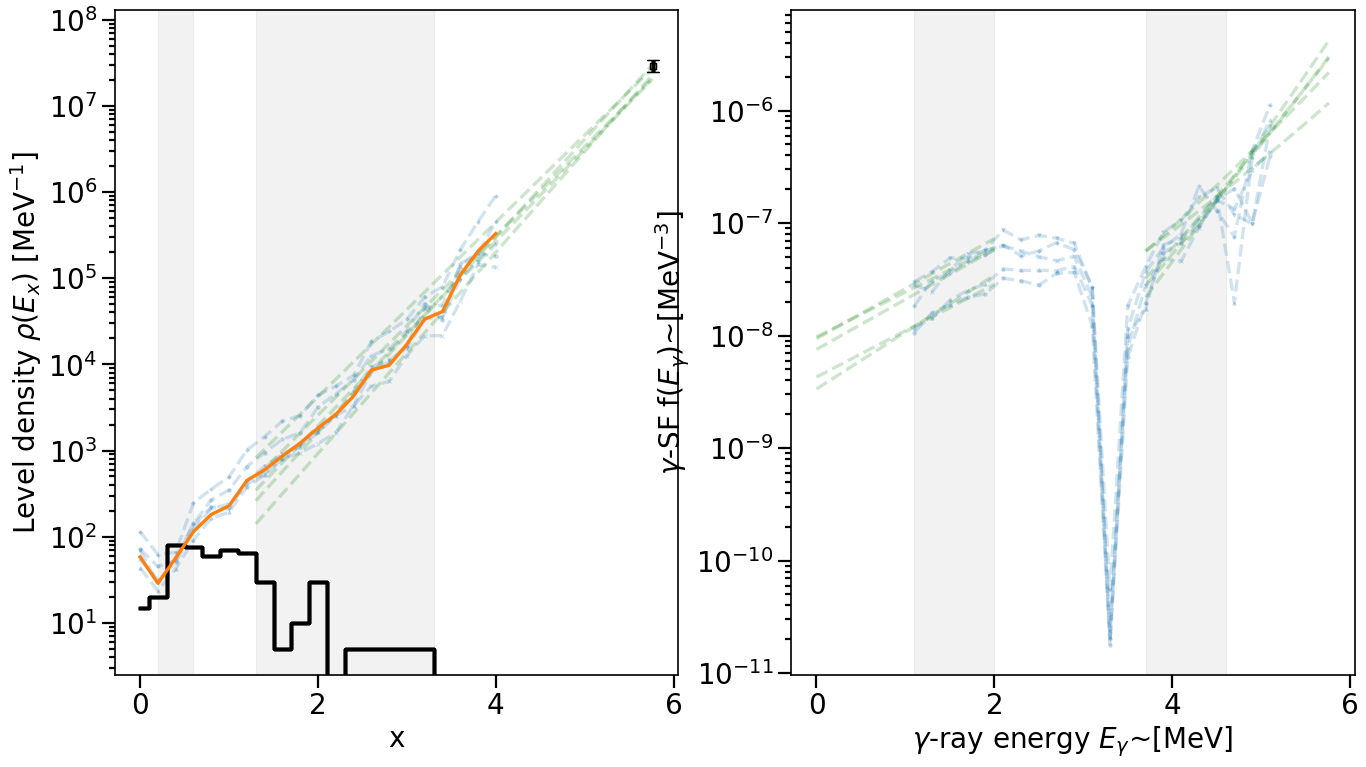

In [26]:
ensemblenorm, fig = norm_sim_ensemble(nldnorm, gsfnorm)

Writing out data ready for analysis

In [27]:
def getMedianQuantile(func):
    """
    Estimating median and the 
    68% confidence interval
    """
    func = pd.DataFrame(func)
    func_median = pd.DataFrame.median(func)
    func_error_low = func.quantile(0.16)
    func_error_high = func.quantile(0.84)
    func_error = func_error_high - func_error_low
    return func_median, func_error

def read_write_ompy(path):
    """
    Read data from saved OmPy results.
    Results to file
    Calculate median and error of results
    Save results to file
    """
    infile = open(path+'README.txt', 'r')
    for line in infile:
        values = line.split()
        if not values:
            continue
        if values[0] == 'rhoSn:':
            rhoSn = float(values[1])
            rhoSn_err = float(values[3])
    infile.close()
    
    parameter_dict = {'keV_per_bin': kev_per_bin_wish, 'Ex_min': Ex_min, 'Ex_max': Ex_max, 'Eg_min': Eg_min, 'Eg_max': Eg_max, 'Gg': Gg, 'Gg_err': Gg_err, 'rhoSn': rhoSn, 'rhoSn_err': rhoSn_err}
    dataFrame1 = pd.DataFrame(parameter_dict, index=[0])
    
    energy_gsf = pd.read_csv(path+'/data/gsf_0.txt', sep=" ", header=None, skiprows=[0, -1])[0]*1e-3
    energy_nld = pd.read_csv(path+'/data/nld_0.txt', sep=" ", header=None, skiprows=[0, -1])[0]*1e-3
    gsf = []
    nld = []
    
    for i in range(ensemble_members-1):
        gsf.append(pd.read_csv(path+'data/gsf_%.0i.txt'%i, sep=" ", header=None, skiprows=[0, -1])[1])
        nld.append(pd.read_csv(path+'data/nld_%.0i.txt'%i, sep=" ", header=None, skiprows=[0, -1])[1])
    
    gsf_median, gsf_error = getMedianQuantile(gsf)
    nld_median, nld_error = getMedianQuantile(nld)
    
    ompy_dict = {'E_gamma': energy_gsf, 'gSF-median':gsf_median, 'gSF-error': gsf_error, 'E_x': energy_nld, 'NLD-median': nld_median, 'NLD-error': nld_error}
    
    #write to file
    dataFrame2 = pd.DataFrame(ompy_dict)
    dataFrame = pd.concat([dataFrame1, dataFrame2])
    dataFrame.to_csv(path+'data_for_analysis.csv')

read_write_ompy(path)